# Surface Freshwater Flux / Virtual Salt Flux: E - P - R

## observational datasets
- precip: Legates, ERAI
- total water flux: Large-Yeager, WHOI

In [1]:
import os
import sys
import time
import string
import numpy as np
import xesmf as xe
import xarray as xr
import cmocean
import cartopy
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
matplotlib.rc_file('rc_file_paper')
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
%load_ext autoreload
%autoreload 2

In [3]:
from tqdm import notebook
from maps import add_cyclic_POP
from paths import path_results, path_prace, file_RMASK_ocn, file_RMASK_ocn_low, file_ex_ocn_ctrl, file_ex_ocn_lpd
from FW_budget import make_SFWF_surface_integrals, make_SFWF_trends
from timeseries import IterateOutputCESM
from xr_DataArrays import xr_AREA
from xr_regression import ocn_field_regression

In [4]:
dh = xr.open_dataset(file_ex_ocn_ctrl, decode_times=False)
dl = xr.open_dataset(file_ex_ocn_lpd , decode_times=False)
RMASK_ocn = dh.REGION_MASK
RMASK_ocn_low = dl.REGION_MASK

In [5]:
dh = xr.open_dataset(file_ex_ocn_ctrl, decode_times=False)
RMASK_ocn = xr.open_dataset(file_ex_ocn_ctrl, decode_times=False).REGION_MASK
RMASK_low = xr.open_dataset(file_RMASK_ocn_low, decode_times=False).REGION_MASK
Atl_MASK_ocn = xr.DataArray(np.in1d(RMASK_ocn, [6,7,8,9,12]).reshape(RMASK_ocn.shape),
                            dims=RMASK_ocn.dims, coords=RMASK_ocn.coords)
Atl_MASK_low = xr.DataArray(np.in1d(RMASK_low, [6,7,8,9,12]).reshape(RMASK_low.shape),
                            dims=RMASK_low.dims, coords=RMASK_low.coords)
AREA_ocn = xr_AREA(domain='ocn')
AREA_low = xr_AREA(domain='ocn_low')

the difference visible in the HIGH on the left is the IOFF_F ice runoff which is not included in the model output, while on the right it is the restoring FW flux, mainly to move freshwater between closed off Baltic/Black/Red Seas and the ocean. Not sure what happens in the Caspian Sea and the Kara(?) Sea

### plot of SFWF means and trends

In [6]:
ds_ctrl = xr.open_dataset(f'{path_prace}/ctrl/EVAP_F_PREC_F_ROFF_F_ctrl_mean_200-230.nc')
EVAP_mean_ctrl = ds_ctrl.EVAP_F
PREC_mean_ctrl = ds_ctrl.PREC_F
ROFF_mean_ctrl = ds_ctrl.ROFF_F
SFWF_mean_ctrl = xr.open_dataarray(f'{path_prace}/ctrl/SFWF_ctrl_mean_200-229.nc')

ds_lpd = xr.open_dataset(f'{path_prace}/lpd/EVAP_F_PREC_F_ROFF_F_lpd_mean_500-530.nc')
EVAP_mean_lpd = ds_lpd.EVAP_F
PREC_mean_lpd = ds_lpd.PREC_F
ROFF_mean_lpd = ds_lpd.ROFF_F
SFWF_mean_lpd = xr.open_dataarray(f'{path_prace}/lpd/SFWF_lpd_mean_500-529.nc')

In [7]:
EVAP_stats_rcp = xr.open_dataset(f'{path_prace}/rcp/EVAP_F_yrly_trend_stats_rcp.nc')
EVAP_stats_lr1 = xr.open_dataset(f'{path_prace}/lr1/EVAP_F_yrly_trend_stats_lr1.nc')
PREC_stats_rcp = xr.open_dataset(f'{path_prace}/rcp/PREC_F_yrly_trend_stats_rcp.nc')
PREC_stats_lr1 = xr.open_dataset(f'{path_prace}/lr1/PREC_F_yrly_trend_stats_lr1.nc')
SFWF_stats_rcp = xr.open_dataset(f'{path_prace}/rcp/SFWF_yrly_trend_stats_rcp.nc')
SFWF_stats_lr1 = xr.open_dataset(f'{path_prace}/lr1/SFWF_yrly_trend_stats_lr1.nc')

EVAP_stats_rcp = EVAP_stats_rcp.assign_coords({'TLONG':RMASK_ocn.TLONG, 'TLAT':RMASK_ocn.TLAT})
PREC_stats_rcp = PREC_stats_rcp.assign_coords({'TLONG':RMASK_ocn.TLONG, 'TLAT':RMASK_ocn.TLAT})
SFWF_stats_rcp = SFWF_stats_rcp.assign_coords({'TLONG':RMASK_ocn.TLONG, 'TLAT':RMASK_ocn.TLAT})

EVAP_trend_rcp = EVAP_stats_rcp.slope
EVAP_trend_lr1 = EVAP_stats_lr1.slope
PREC_trend_rcp = PREC_stats_rcp.slope
PREC_trend_lr1 = PREC_stats_lr1.slope
SFWF_trend_rcp = SFWF_stats_rcp.slope
SFWF_trend_lr1 = SFWF_stats_lr1.slope

In [8]:
def regrid_rectangular(da):
    """ regrids to rectangular grid """
    assert 'lat' in da.coords
    assert 'lon' in da.coords
    target = xr.DataArray(coords={'lat':np.arange(89.5,-90,-1), 'lon':np.arange(-179.5,180,1)}, dims=['lat','lon'])
    regridder = xe.Regridder(da, target, 'nearest_s2d', reuse_weights=True, periodic=True)
    da_regridded = regridder(da)
    return da_regridded

Reuse existing file: nearest_s2d_2400x3600_180x360_peri.nc


/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: nearest_s2d_384x320_180x360_peri.nc


/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: nearest_s2d_2400x3600_180x360_peri.nc


/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: nearest_s2d_384x320_180x360_peri.nc


/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: nearest_s2d_2400x3600_180x360_peri.nc


/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: nearest_s2d_384x320_180x360_peri.nc


/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


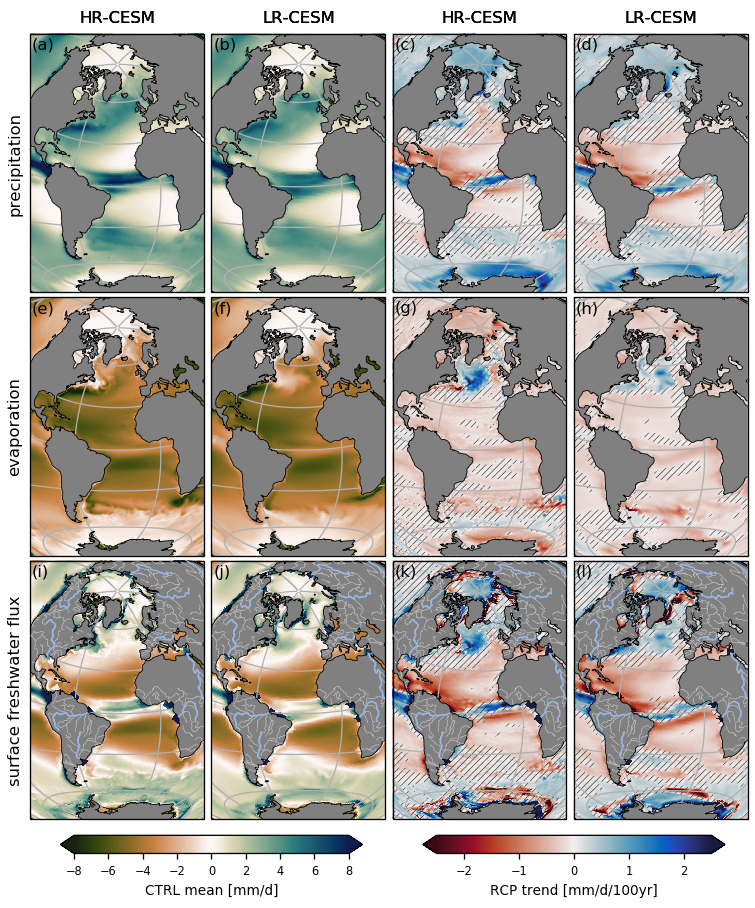

In [9]:
f = plt.figure(figsize=(6.4,7.7))
for i in range(3):
    f.text(.01,.82-i*.29,['precipitation', 'evaporation', 'surface freshwater flux'][i], rotation='vertical', va='center', ha='left')
    for j in range(4):
        Q = [[PREC_mean_ctrl, EVAP_mean_ctrl, SFWF_mean_ctrl],
             [PREC_mean_lpd , EVAP_mean_lpd , SFWF_mean_lpd ],
             [PREC_trend_rcp, EVAP_trend_rcp, SFWF_trend_rcp],
             [PREC_trend_lr1, EVAP_trend_lr1, SFWF_trend_lr1]][j][i]
        if j<2:  # means
            minv, maxv = -8, 8
            Q = Q.where([RMASK_ocn, RMASK_ocn_low][j]>0)*24*3600
            cmap = 'cmo.tarn'
        else:  # trends
            minv, maxv = -2.5, 2.5
            Q = Q.where([RMASK_ocn, RMASK_ocn_low][j%2]>0)*24*3600*365*100
            if j==3:
                Q = Q.assign_coords({'TLONG':RMASK_low.TLONG, 'TLAT':RMASK_low.TLAT})
            cmap = 'cmo.balance_r'
        f.text(.155+j*(.24), .975, ['HR-CESM', 'LR-CESM'][j%2], ha='center')
    
        ax = f.add_axes([.04+j*(.24),.66-i*.29,.23,.32], projection=ccrs.LambertAzimuthalEqualArea(central_longitude=-30, central_latitude=20))
        ax.set_extent((-6e6, 3.5e6, -8.5e6, 1e7), crs=ccrs.LambertAzimuthalEqualArea())
        da = add_cyclic_POP(Q)
        im = ax.pcolormesh(da.TLONG, da.TLAT, da, transform=ccrs.PlateCarree(),
                           cmap=cmap, zorder=0, vmin=minv, vmax=maxv) # kg/m2/s to mm/d
        
        if j>1:  # hatches
            xa = [None,
                  None,
                  [PREC_stats_rcp, EVAP_stats_rcp, SFWF_stats_rcp],
                  [PREC_stats_lr1, EVAP_stats_lr1, SFWF_stats_lr1]][j][i]
            rn = {'TLAT':'lat', 'TLONG':'lon'}
            drop = ['ULONG','ULAT']
            da = xr.where(np.isfinite(xa.p_value),xa.p_value,0).rename(rn).drop(drop)
            pvalue = regrid_rectangular(da)
            ax.contourf(pvalue.lon, pvalue.lat, pvalue, [0,0.05,1],
                        colors='none', hatches=[None,'//////'], transform=ccrs.PlateCarree())
        
        if j==1 and i==2:
            cax = f.add_axes([.08,.06,.4,.02])
        if j==3 and i==2:
            cax = f.add_axes([.56,.06,.4,.02])
        if j in [1,3] and i==2:
            cbar = f.colorbar(im, cax=cax, extend='both', orientation='horizontal',\
                              label=['','CTRL mean [mm/d]','','RCP trend [mm/d/100yr]'][j])
            
        ax.add_feature(cartopy.feature.LAND, zorder=2, edgecolor='black', facecolor='grey', linewidth=.5)
        if i==2:
            rivers = cartopy.feature.NaturalEarthFeature(
                        category='physical', name='rivers_lake_centerlines',
                        scale='50m', facecolor='none', edgecolor='lightgrey')
            ax.add_feature(rivers, linewidth=.3, zorder=3)
            ax.add_feature(cartopy.feature.RIVERS, zorder=4)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
        gl.ylocator = matplotlib.ticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
        ax.text(.01,.94,'('+string.ascii_lowercase[i*4+j]+')', transform=ax.transAxes)
        
plt.savefig(f'{path_results}/SFWF/SFWF_maps', dpi=300)
plt.savefig(f'{path_results}/FW-paper/SFWF_maps', dpi=300)
plt.savefig(f'{path_results}/FW-paper/Fig6', dpi=300)


### dictionary of regionally integrated SFWFs

In [11]:
make_SFWF_surface_integrals()

----- HIGH -----

-34N to 60N,   6.41E+13 m^2

             PREC  EVAP  ROFF  TOTAL   DIFF
[mm/d]       2.62 -4.43  0.62 -1.1499  0.0360
[mm/d/100y] -0.11 -0.14  0.07 -0.2054 -0.0277
[Sv]         1.94 -3.28  0.46 -0.8532  0.0267
[Sv/100y]   -0.08 -0.10  0.05 -0.1524 -0.0205
[%/100y]     -4.2   3.1  11.4  17.9

total surface flux:   -0.85 Sv  -0.15 Sv/100yr   17.9 %/100yr





-34N to -10N,   1.58E+13 m^2

             PREC  EVAP  ROFF  TOTAL   DIFF
[mm/d]       1.47 -4.51  0.09 -2.9454  0.0000
[mm/d/100y] -0.01 -0.19  0.01 -0.1872 -0.0000
[Sv]         0.27 -0.83  0.02 -0.5392  0.0000
[Sv/100y]   -0.00 -0.03  0.00 -0.0343 -0.0000
[%/100y]     -0.8   4.2  14.9   6.4

total surface flux:   -0.54 Sv  -0.03 Sv/100yr    6.4 %/100yr





-10N to 10N,   1.29E+13 m^2

             PREC  EVAP  ROFF  TOTAL   DIFF
[mm/d]       3.53 -4.37  1.84  0.9979  0.0000
[mm/d/100y] -0.09 -0.30  0.30 -0.0957  0.0000
[Sv]         0.53 -0.65  0.28  0.1493  0.0000
[Sv/100y]   -0.01 -0.05  0.04 -0.0143  0.0000
[%